
**1 -Import Relevent Packages and Libraries**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time


**2 - Basic Optimization with GradientTape**

The beauty of TensorFlow 2 is in its simplicity. Basically, all you need to do is implement forward propagation through a computational graph. TensorFlow will compute the derivatives for you, by moving backwards through the graph recorded with `GradientTape`. All that's left for you to do then is specify the cost function and optimizer you want to use! 



We will Use the Fashion Mnsist Dataset from Tensorflow dataset

In [ ]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train = tf.data.Dataset.from_tensor_slices(x_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)

x_test = tf.data.Dataset.from_tensor_slices(x_test)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

In [ ]:
type(x_train)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

Since TensorFlow Datasets are generators, we can't access directly the contents unless you iterate over them in a for loop, or by explicitly creating a Python iterator using `iter` and consuming its
elements using `next`. Also, you can inspect the `shape` and `dtype` of each element using the `element_spec` attribute.

In [ ]:
print(x_train.element_spec)

TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None)


In [ ]:
print(y_train.element_spec)

TensorSpec(shape=(), dtype=tf.uint8, name=None)


The fashion mnsist dataset that we are using  contains 10 different classes representing the digits from 0 to 9 

You can see some of the images in the dataset by running the following cell.

In [ ]:
category_list = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

category_dict = {i : j for i , j  in enumerate(category_list) }

In [ ]:
category_dict

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [ ]:
def plot_images(x_train,y_train,categories) :

  images = iter(x_train)
  labels = iter(y_train)

  plt.figure(figsize=(10, 10))
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(next(images).numpy().astype("uint8"),cmap='gray')
    plt.title( categories[next(labels).numpy().astype("uint8")] )
    plt.axis("off")


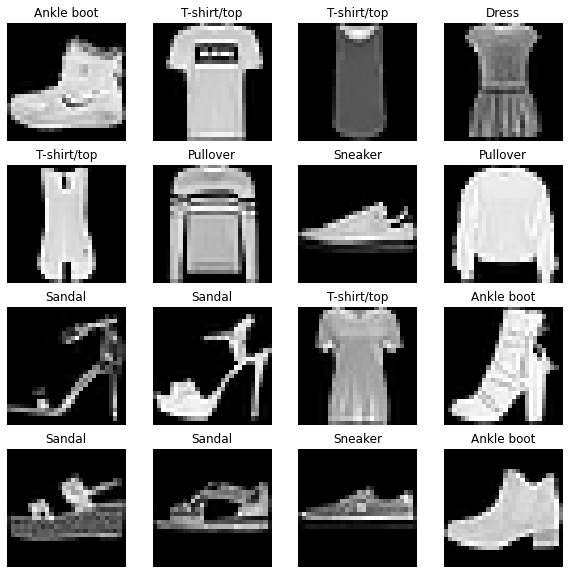

In [ ]:
plot_images(x_train,y_train,category_dict)

There's one more additional difference between TensorFlow datasets and Numpy arrays: If you need to transform one, you would invoke the `map` method to apply the function passed as an argument to each of the elements.

In [ ]:
def normalize(image):
    """
    Transform an image into a tensor of shape (28 * 28 * 1)
    and normalize its components.
    
    Arguments
    image - Tensor.
    
    Returns: 
    result -- Transformed tensor 
    """
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1,])
    
    return image

In [ ]:
new_train = x_train.map(normalize)
new_test = x_test.map(normalize)

In [ ]:
print(new_train.element_spec)

TensorSpec(shape=(784,), dtype=tf.float32, name=None)


**3 - Using One Hot Encodings**

Many times in deep learning you will have a $Y$ vector with numbers ranging from $0$ to $C-1$, where $C$ is the number of classes. If $C$ is for example 4, then you might have the following y vector.

**[0 1 0 0]**

This is called "one hot" encoding, because in the converted representation, exactly one element of each column is "hot" (meaning set to 1). To do this conversion in numpy, you might have to write a few lines of code. In TensorFlow, you can use one line of code: 

`axis=0` indicates the new axis is created at dimension 0

**one_hot_matrix**

the function below takes one label and the total number of classes $C$, and return the one hot encoding in a column wise matrix. 

In [ ]:
def one_hot_matrix(label, depth=10):
    """
    Computes the one hot encoding for a single label
    
    Arguments:
        label --  (int) Categorical labels
        depth --  (int) Number of different classes that label can take
    
    Returns:
         one_hot -- tf.Tensor A single-column matrix with the one hot encoding.
    """
    one_hot = tf.reshape(tf.one_hot(label,depth=depth,axis=0),shape=(depth,))
    
    return one_hot

In [ ]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

In [ ]:
print(next(iter(new_y_test)))

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)


**4 Initialize the Parameters**

We are implementing a 3 layer neural network (One hidden layer + Output)

We initialize a vector of numbers with the Glorot initializer. The function  is `tf.keras.initializers.GlorotNormal`, which draws samples from a truncated normal distribution centered on 0, with `stddev = sqrt(2 / (fan_in + fan_out))`, where `fan_in` is the number of input units and `fan_out` is the number of output units, both in the weight tensor. 


In [ ]:
def initialize_parameters(layer_dim):
    """

    Initializes parameters to build a neural network with TensorFlow. 

    Arguments :

    layer_dims -- list of length 3 containing node in each layer
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2
    """


    input ,hidden ,output = layer_dim

    initializer = tf.keras.initializers.GlorotNormal(seed=1)   

    W1 = tf.Variable(initializer(shape=(hidden,input)))
    b1 = tf.Variable(initializer(shape=(hidden,1)))

    W2 = tf.Variable(initializer(shape=(output,hidden)))
    b2 = tf.Variable(initializer(shape=(output,1)))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2
                  }
    
    return parameters

In [ ]:
parameters = initialize_parameters([784,1000,10])

In [ ]:
assert (parameters['W1'].shape == (1000,784)),'Wrong shape of W1'
assert (parameters['b1'].shape == (1000,1)),'Wrong shape of b1'
assert (parameters['W2'].shape == (10,1000)),'Wrong shape of W2'
assert (parameters['b2'].shape == (10,1)),'Wrong shape of b2'

**3 - Building Neural Network in TensorFlow**

- Implement forward propagation and let tensorflow handle the backward propagation
- Retrieve the gradients and train the model


**3.1 - Implement Forward Propagation**

One of TensorFlow's great strengths lies in the fact that we only need to implement the forward propagation function and it will keep track of the operations we did to calculate the back propagation automatically.  



In [ ]:
def forward_propagation(X, parameters):


    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z2 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
                     
    Z1 = tf.math.add( tf.linalg.matmul(W1,X) ,b1 )                         
    A1 = tf.keras.activations.relu(Z1)                                                           
    Z2 = tf.math.add( tf.linalg.matmul(W2,A1) ,b2 )                                                 
    
    return Z2

**3.2 Compute the Cost**

All you have to do now is define the loss function that you're going to use. For this case, since we have a classification problem with 6 labels, a categorical cross entropy will work! 

In [ ]:
def compute_cost(logits, labels):
    """
    Computes the cost
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (6, num_examples)
    labels -- "true" labels vector, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    #(1 line of code)
    cost = tf.reduce_mean( tf.keras.losses.categorical_crossentropy(y_true=tf.transpose(labels),y_pred=tf.transpose(logits),from_logits=True )) 
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE
    return cost

 3.3 - Train the Model

We need to specify the type of optimizer in one line, in this case `tf.keras.optimizers.Adam` (we can use other optimizers such as SGD,RMSProp etc), and then call it within the training loop. 

The `tape.gradient` function: this allows you to retrieve the operations recorded for automatic differentiation inside the `GradientTape` block. Then, calling the optimizer method `apply_gradients`, will apply the optimizer's update rules to each trainable parameter. At the end of this assignment, you'll find some documentation that explains this more in detail, but for now, a simple explanation will do. ;) 


Here we should take note of an important extra step that's been added to the batch training process: 

- `tf.Data.dataset = dataset.prefetch(8)` 

What this does is prevent a memory bottleneck that can occur when reading from disk. `prefetch()` sets aside some data and keeps it ready for when it's needed. It does this by creating a source dataset from your input data, applying a transformation to preprocess the data, then iterating over the dataset the specified number of elements at a time. This works because the iteration is streaming, so the data doesn't need to fit into the memory. 

In [ ]:
def model(X_train, Y_train, learning_rate = 1e-2,
          num_epochs = 100, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 784, number of training examples = 60000)
    Y_train -- test set, of shape (output size = 10, number of training examples = 60000)
  
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop

    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every epoch
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    #to keep track of cost and accuracy (train and test)
    costs = []                                       
    train_acc = []
    
    # Initialize your parameters 
    parameters = initialize_parameters([784,1000,10])

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    # The CategoricalAccuracy will track the accuracy for this multiclass problem
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    
    # We can get the number of elements of a dataset using the cardinality method
    m = dataset.cardinality().numpy()
    
    # Convert the data in batches (example,label) of size 32
    minibatches = dataset.batch(minibatch_size).prefetch(8)

    X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
    Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 

    # Do the training loop
    for epoch in range(num_epochs):

        epoch_cost = 0.
        
        #We need to reset object to start measuring from 0 the accuracy each epoch
        train_accuracy.reset_states()
        
        for (minibatch_X, minibatch_Y) in minibatches :
            
            with tf.GradientTape() as tape:
                # 1. predict
                Z2 = forward_propagation(tf.transpose(minibatch_X), parameters)

                # 2. loss
                minibatch_cost = compute_cost(Z2, tf.transpose(minibatch_Y))

            # We acumulate the accuracy of all the batches
            train_accuracy.update_state(tf.transpose(Z2), minibatch_Y)
            
            trainable_variables = [W1, b1, W2, b2]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_cost += minibatch_cost
        
        # We divide the epoch cost over the number of samples
        epoch_cost /= m

        # Print the cost and train accuracy after every epoch
        print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        print("Train accuracy:", train_accuracy.result())
            
      

        costs.append(epoch_cost)
        train_acc.append(train_accuracy.result())

    return parameters, costs, train_acc, test_acc

In [ ]:
parameters, costs, train_acc, test_acc = model(new_train, new_y_train, num_epochs=100)

Cost after epoch 0: 0.017416
Train accuracy: tf.Tensor(0.80965, shape=(), dtype=float32)
Cost after epoch 1: 0.013734
Train accuracy: tf.Tensor(0.84245, shape=(), dtype=float32)
Cost after epoch 2: 0.012869
Train accuracy: tf.Tensor(0.8527333, shape=(), dtype=float32)
Cost after epoch 3: 0.012427
Train accuracy: tf.Tensor(0.85801667, shape=(), dtype=float32)
Cost after epoch 4: 0.012210
Train accuracy: tf.Tensor(0.86005, shape=(), dtype=float32)
Cost after epoch 5: 0.011935
Train accuracy: tf.Tensor(0.86286664, shape=(), dtype=float32)
Cost after epoch 6: 0.011872
Train accuracy: tf.Tensor(0.863, shape=(), dtype=float32)
Cost after epoch 7: 0.011555
Train accuracy: tf.Tensor(0.86685, shape=(), dtype=float32)
Cost after epoch 8: 0.011481
Train accuracy: tf.Tensor(0.86808336, shape=(), dtype=float32)
Cost after epoch 9: 0.011295
Train accuracy: tf.Tensor(0.86906666, shape=(), dtype=float32)
Cost after epoch 10: 0.011159
Train accuracy: tf.Tensor(0.871, shape=(), dtype=float32)
Cost after

In [ ]:
def evaluate_on_test(x_test,y_test,parameters) :

  '''evaluate the model on a test data
  Arguments :
  x_test -- test data (num_features ,num_examples)
  y_test -- test labels (num_classes,num_examples)
  '''

  #Convert the data and label into batches 
  test_dataset = tf.data.Dataset.zip((x_test, y_test)) 

  test_minibatches = test_dataset.batch(1).prefetch(8)

  test_accuracy = tf.keras.metrics.CategoricalAccuracy()

  #
  for (minibatch_X, minibatch_Y) in test_minibatches:
      Z2 = forward_propagation(tf.transpose(minibatch_X), parameters)
      test_accuracy.update_state(tf.transpose(Z2), minibatch_Y)

  print("Test_accuracy:", test_accuracy.result())

In [ ]:
evaluate_on_test(new_test, new_y_test,parameters)

Test_accuracy: tf.Tensor(0.821, shape=(), dtype=float32)


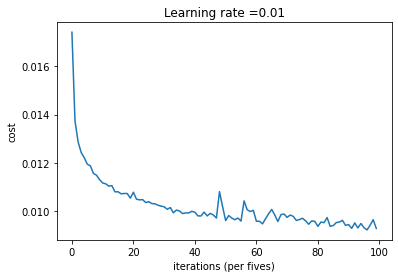

In [ ]:
# Plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.01))
plt.show()


Text(0.5, 1.0, 'Learning rate =0.01')

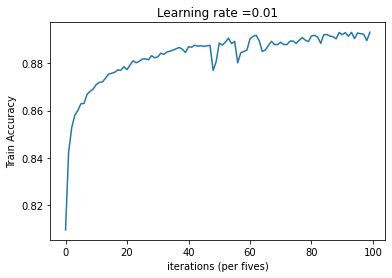

In [ ]:
# Plot the train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.01))

